In [1]:
import random
import statistics
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.stats import linregress
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from scipy.constants import k as k_B  # Boltzmann constant in J/K
from scipy.constants import G, proton_mass
from functools import partial
# from lab_functions_1 import Ax, vcgrab, Tc, Lambdacalc, dLdTfunc, dVcdrfunc
import lab_functions_1 as lf
import WiersmaCopy as Cool
G = 6.6743*10**-8
mp_g = proton_mass*1e3
k_Bcgs = k_B*1e7
mu = 0.6
gamma = 5/3
ktc = 3.0857e21
etkv = 6.2415*10**8

In [2]:
# Create an instance of the cooling object
Z2Zsun = 0.3  # solar metallicity
z = 0.6       # redshift
cooling = Cool.Wiersma_Cooling(Z2Zsun=Z2Zsun, z=z)

# Generate random test values for T and nH
n_samples = 5
T_samples = 10**np.random.uniform(4.2, 8.16, size=n_samples)      # T from 1e4 to 1e8 K
nH_samples = 10**np.random.uniform(-3.7, -0.52, size=n_samples)    # nH from 1e-6 to 1e2 cm^-3

# Test LAMBDA
print("T [K]       nH [cm^-3]     Lambda [erg cm^3 / s]")
for T, nH in zip(T_samples, nH_samples):
    Lambda_val = cooling.LAMBDA(T, nH)
    print(f"{T: .2e}   {nH: .2e}     {Lambda_val: .2e}")

T [K]       nH [cm^-3]     Lambda [erg cm^3 / s]
 9.18e+06    5.31e-04      1.40e-23
 3.58e+07    5.29e-03      1.78e-23
 4.34e+07    2.41e-03      1.98e-23
 5.71e+06    1.07e-01      1.36e-23
 3.90e+04    2.81e-02      5.88e-23


c:\Users\Jacob\vscode library\WiersmaCopy.py:36: RuntimeWarning: invalid value encountered in log10
  self.logLambda_table = np.log10(Cooling_Table)
c:\Users\Jacob\vscode library\WiersmaCopy.py:47: RuntimeWarning: invalid value encountered in log
  log_vals = np.log(self.f_Cooling((np.log10(Xg), np.log10(Yg))))


-3.1396549737218393


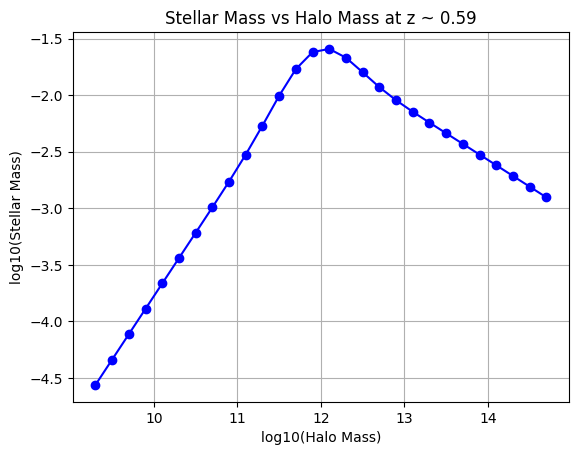

In [3]:
left = np.array([9.3, 9.5, 9.7, 9.9, 10.1, 10.3, 10.5, 10.7, 10.9, 11.1, 11.3, 11.5, 11.7, 11.9, 12.1, 12.3, 12.5, 12.7, 12.9, 
    13.1, 13.3, 13.5, 13.7, 13.9, 14.1, 14.3, 14.5, 14.7])

right = np.array([-4.560623, -4.336346, -4.1121, -3.887918, -3.663862, -3.440012, -3.216311, -2.991903, -2.763624, -2.524845, 
    -2.269454, -2.005525, -1.769973, -1.619732, -1.591587, -1.669076, -1.79781, -1.929445, -2.045038, -2.146987, -2.242711, 
    -2.336809, -2.430866, -2.525143, -2.61958, -2.714102, -2.808667, -2.903251])

f = interp1d(left, right, kind='cubic', fill_value='extrapolate')
print(f(15.2))

plt.plot(left, right, marker='o', linestyle='-', color='b')
plt.xlabel('log10(Halo Mass)')
plt.ylabel('log10(Stellar Mass)')
plt.title('Stellar Mass vs Halo Mass at z ~ 0.59')
plt.grid(True)
plt.show()

In [4]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
z = 0.597
rho_m = cosmo.Om(z) * cosmo.critical_density(z)
rho_m = rho_m.value
x = cosmo.Om(z) - 1
delc = 18 * np.pi**2 + 82 * x - 39 * x**2
delm = delc / cosmo.Om(z)
Rvir = (3 * 2e15 * 1.988e33 / (4 * np.pi * delm * rho_m))**(1/3)
R500 = (3 * 2e15 * 1.988e33 / (4 * np.pi * 500 * cosmo.critical_density(z).value))**(1/3)
print(f"Rvir = {Rvir/ktc} rs = {Rvir/(5*ktc)}")
print(R500/ktc)

Rvir = 2339.620132916565 rs = 467.924026583313
1540.0742726110752


In [5]:
print(mpl.colors.get_named_colors_mapping())

{'xkcd:cloudy blue': '#acc2d9', 'xkcd:dark pastel green': '#56ae57', 'xkcd:dust': '#b2996e', 'xkcd:electric lime': '#a8ff04', 'xkcd:fresh green': '#69d84f', 'xkcd:light eggplant': '#894585', 'xkcd:nasty green': '#70b23f', 'xkcd:really light blue': '#d4ffff', 'xkcd:tea': '#65ab7c', 'xkcd:warm purple': '#952e8f', 'xkcd:yellowish tan': '#fcfc81', 'xkcd:cement': '#a5a391', 'xkcd:dark grass green': '#388004', 'xkcd:dusty teal': '#4c9085', 'xkcd:grey teal': '#5e9b8a', 'xkcd:macaroni and cheese': '#efb435', 'xkcd:pinkish tan': '#d99b82', 'xkcd:spruce': '#0a5f38', 'xkcd:strong blue': '#0c06f7', 'xkcd:toxic green': '#61de2a', 'xkcd:windows blue': '#3778bf', 'xkcd:blue blue': '#2242c7', 'xkcd:blue with a hint of purple': '#533cc6', 'xkcd:booger': '#9bb53c', 'xkcd:bright sea green': '#05ffa6', 'xkcd:dark green blue': '#1f6357', 'xkcd:deep turquoise': '#017374', 'xkcd:green teal': '#0cb577', 'xkcd:strong pink': '#ff0789', 'xkcd:bland': '#afa88b', 'xkcd:deep aqua': '#08787f', 'xkcd:lavender pink': 

In [6]:
y = np.log10(np.array([3324.598, 1522.680, 1553.475, 1297.309, 725.888, 594.173, 374.898, 346.043, 214.010, 193.623, 155.348, 137.762, 127.159, 112.765,
    96.075, 85.199, 78.642, 69.739, 57.085, 51.647, 39.811, 35.304, 33.246, 30.079, 16.830, 14.925, 14.055, 12.716, 9.607, 8.185,
    4.228, 3.008, 2.563, 1.975]))

y_pairs = y.reshape(-1, 2)

# Compute symmetric error for each pair
errors = np.abs(y_pairs[:, 0] - y_pairs[:, 1]) / 2
stdvi = errors**2

print(stdvi)

[0.02875237 0.00153119 0.00189037 0.00030247 0.00047257 0.00068059
 0.0006805  0.00068058 0.00068066 0.00047256 0.00068067 0.00047254
 0.00068042 0.00047263 0.00120997 0.00546543 0.00320251]


C:\Users\Jacob\AppData\Local\Temp\ipykernel_13216\3432144498.py:13: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


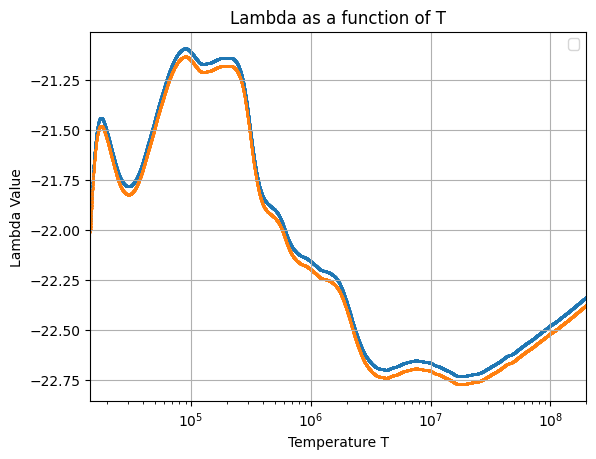

In [7]:
T_grid = np.logspace(4.16, 10, 10000)
L_grid = np.log10(np.array([lf.Lambdacalc(T, 1000*ktc, "a", 1) for T in T_grid]))
L_grid2 = np.log10(np.array([lf.Lambdacalc(T, 1000*ktc, 0.3, 1) for T in T_grid]))

plt.scatter(T_grid, L_grid, s=1)
plt.scatter(T_grid, L_grid2, s=1)
plt.xlabel('Temperature T')
plt.ylabel('Lambda Value')
plt.xscale('log')
plt.xlim(10**4.16, 2e8)
#plt.yscale('log')
plt.title('Lambda as a function of T')
plt.legend()
plt.grid(True)
plt.show()

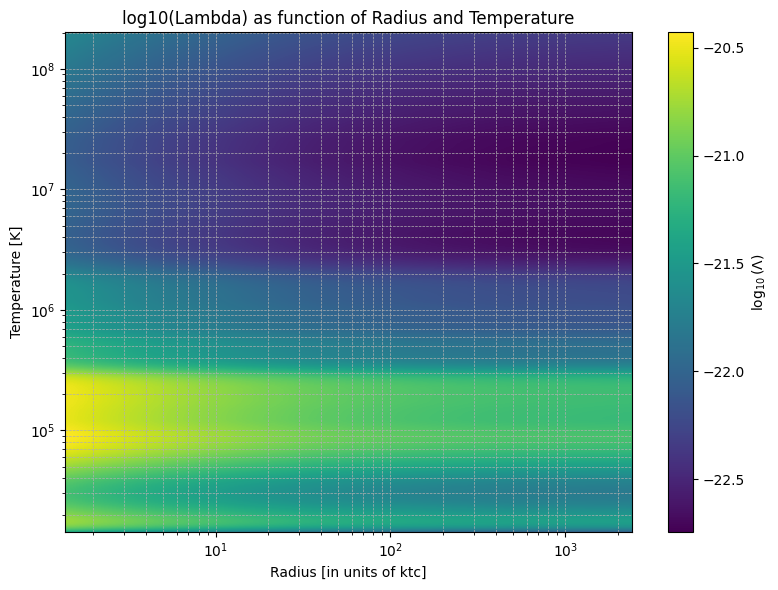

In [10]:
# Define temperature and radius grids
T_vals = np.logspace(4.16, 8.3, 500)      # Temperature range [K]
R_vals = np.logspace(0.14, 3.38, 500) * ktc   # Radius range [code units to physical, adjust as needed]

# Create meshgrid for evaluation
T_mesh, R_mesh = np.meshgrid(T_vals, R_vals, indexing='ij')

# Evaluate Lambda for each (T, R) pair
Lambda_grid = np.zeros_like(T_mesh)

for i in range(T_mesh.shape[0]):
    for j in range(T_mesh.shape[1]):
        T = T_mesh[i, j]
        R = R_mesh[i, j]
        Lambda_grid[i, j] = lf.Lambdacalc(T, R, "a", 1)  # Replace "a", 1 with actual args if needed

# Convert to log10 for plotting clarity
log_Lambda = np.log10(Lambda_grid)

# Plotting
plt.figure(figsize=(8, 6))
pcm = plt.pcolormesh(R_vals / ktc, T_vals, log_Lambda, shading='auto', cmap='viridis')
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Radius [in units of ktc]")
plt.ylabel("Temperature [K]")
plt.title("log10(Lambda) as function of Radius and Temperature")
cbar = plt.colorbar(pcm, label=r"$\log_{10}(\Lambda)$")
plt.grid(True, which='both', ls='--', lw=0.5)
plt.tight_layout()
plt.show()